Prepare you environment

In [5]:
!pip install requests pandas

Once you environment is ready you will want to create a shortcut in your Google Drive account to the hackathon's [Google drive](https://drive.google.com/drive/u/0/folders/1qeMOeW5qHd6PRxnz0jjqmnAj2BiToWmN) folder that contains our sample datasets from the Data Citation Corpus.

To do that, login to Google Drive and then create a shortcut:

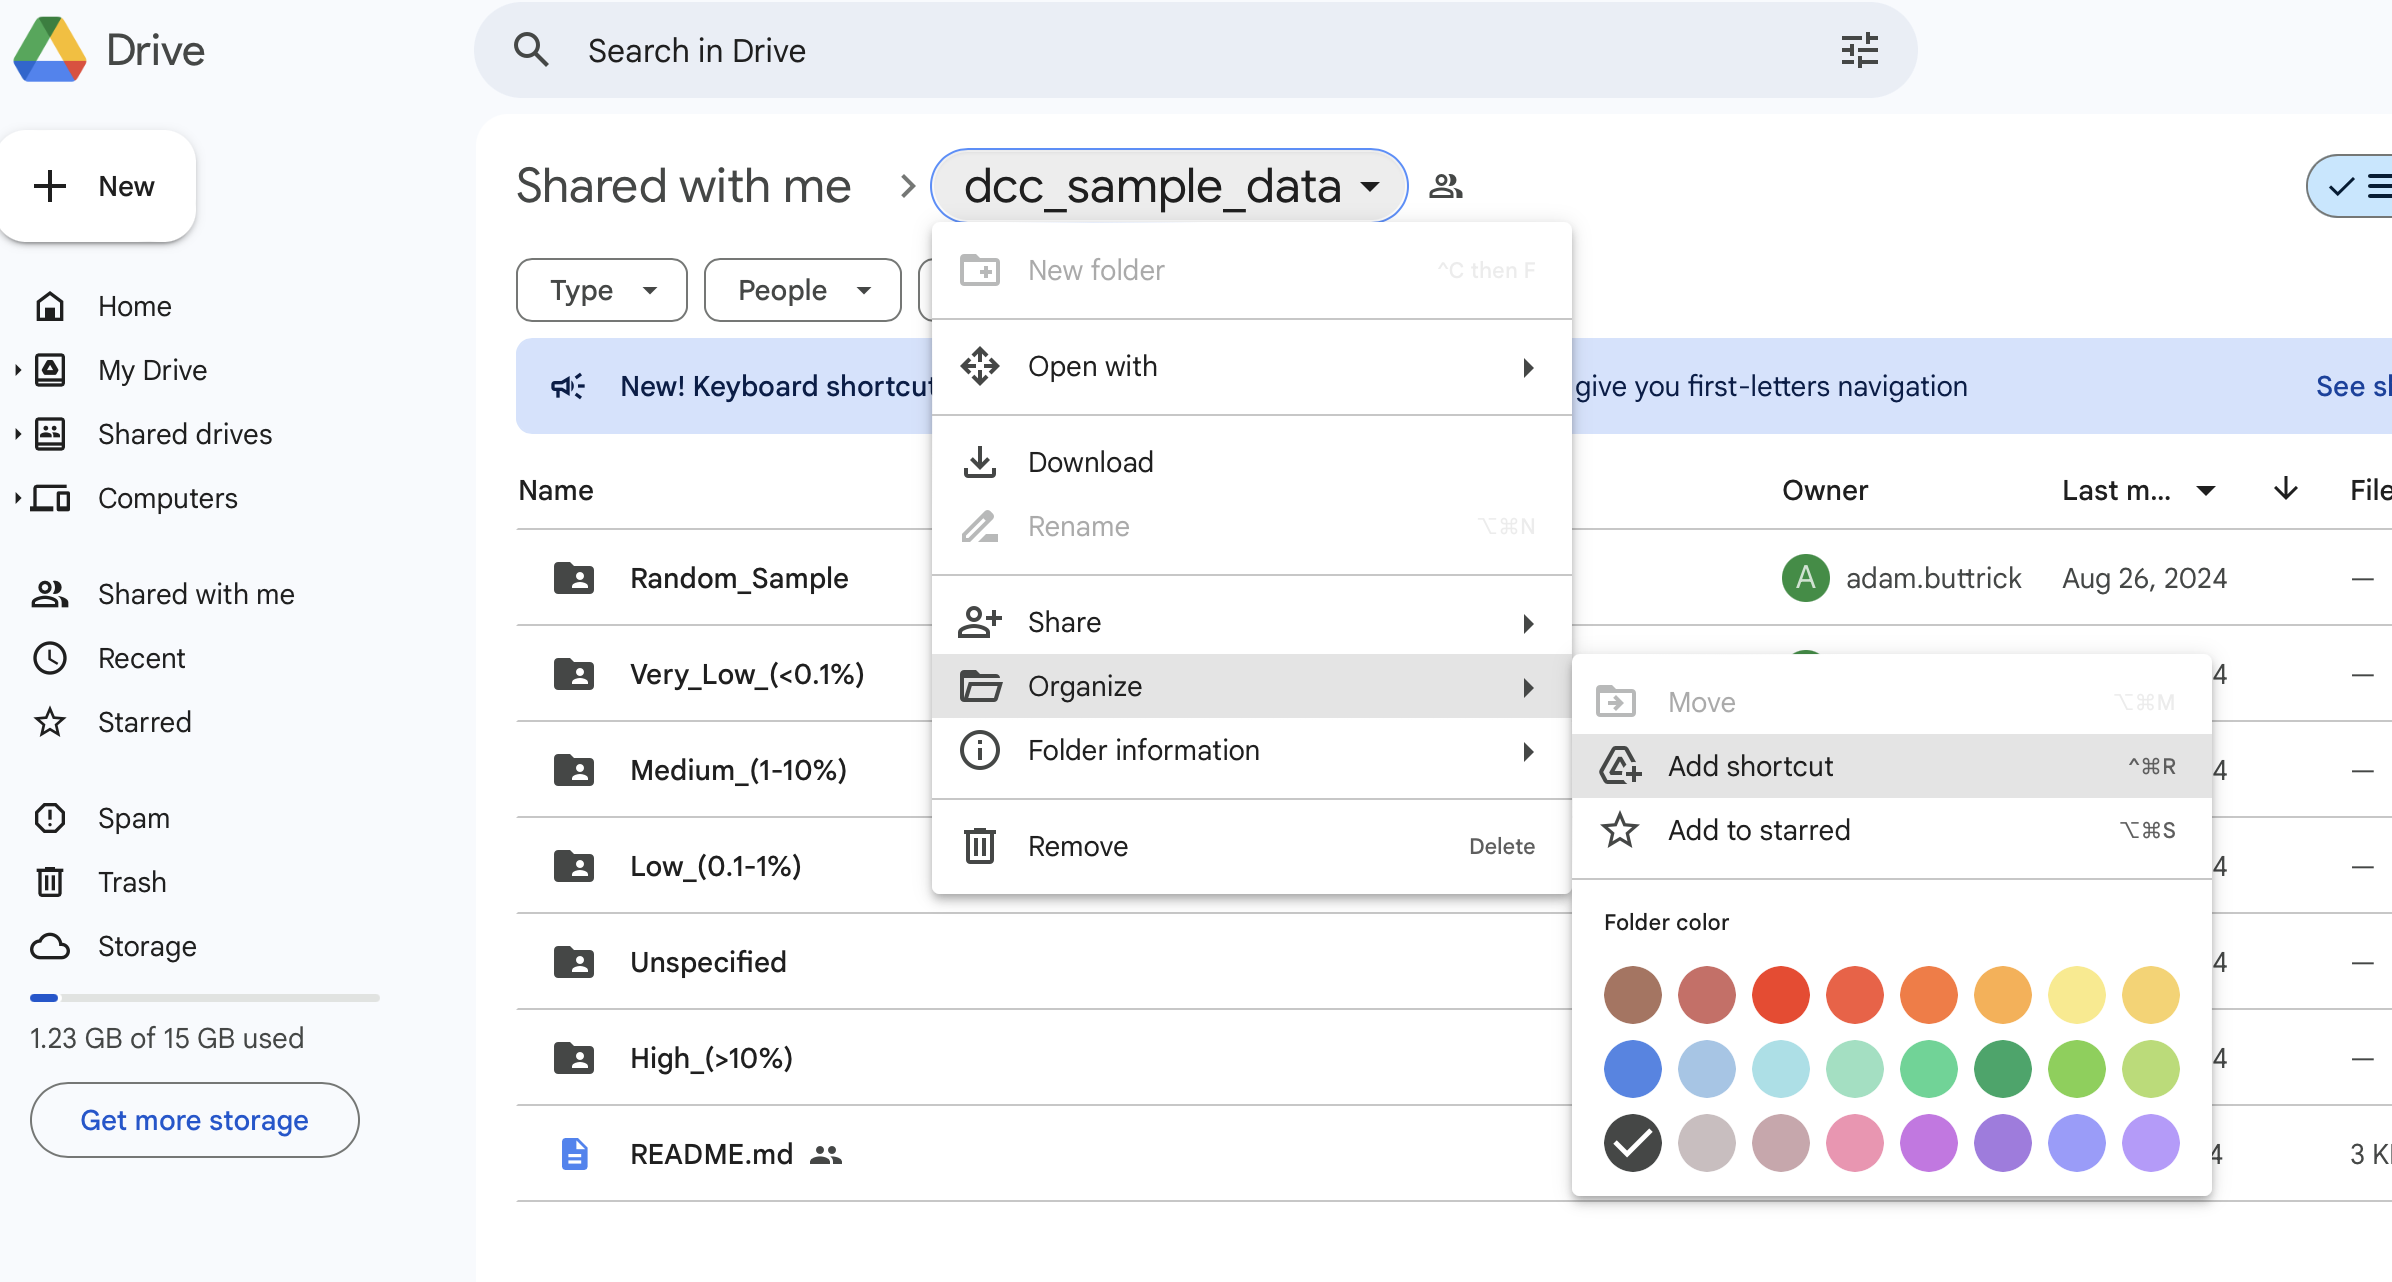

And then select 'My Drive' as the location you want to add the shortcut to. 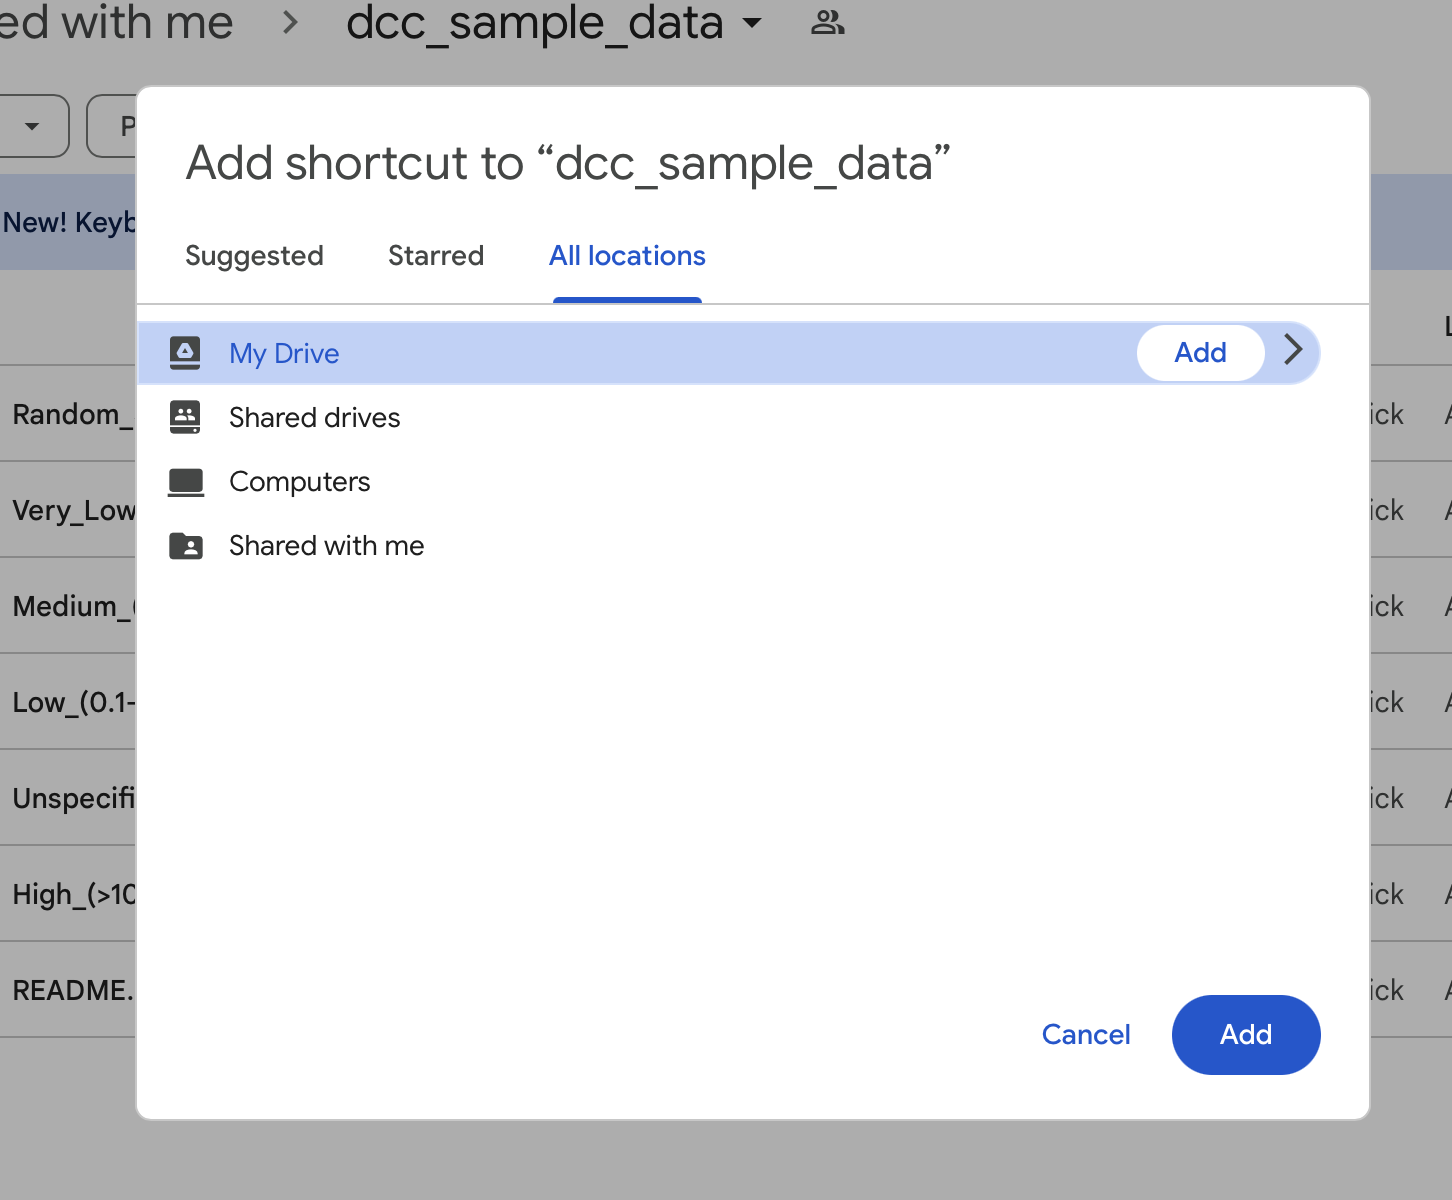

Then mount the your Google drive so that we can access all of the sample datasets.

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Now let's take a look at the contents of the Google drive. You can reference the [README](https://drive.google.com/drive/u/0/folders/1qeMOeW5qHd6PRxnz0jjqmnAj2BiToWmN) in a separate tab to see the description of the sample datasets.

In [7]:
import os

# Function to list all files in a directory
def list_files_in_directory(directory_path):
    for root, dirs, files in os.walk(directory_path):
        print(f'Root directory: {root}')
        print('Subdirectories:')
        for dir_name in dirs:
            print(f'  {dir_name}')
        print('Files:')
        for file_name in files:
            print(f'  {file_name}')
        print('')

# Step 2: List all subdirectories and files within them
list_files_in_directory('/content/drive/MyDrive/dcc_sample_data')

Root directory: /content/drive/MyDrive/dcc_sample_data
Subdirectories:
  Very_Low_(<0.1%)
  Random_Sample
  Low_(0.1-1%)
  Unspecified
  High_(>10%)
  Medium_(1-10%)
Files:
  README.md

Root directory: /content/drive/MyDrive/dcc_sample_data/Very_Low_(<0.1%)
Subdirectories:
Files:
  sample_1.csv
  sample_1.json
  sample_2.csv
  sample_3.csv
  sample_2.json
  sample_3.json

Root directory: /content/drive/MyDrive/dcc_sample_data/Random_Sample
Subdirectories:
  Random
Files:

Root directory: /content/drive/MyDrive/dcc_sample_data/Random_Sample/Random
Subdirectories:
Files:
  sample_1.csv
  sample_2.csv
  sample_1.json
  sample_2.json
  sample_3.csv
  sample_3.json

Root directory: /content/drive/MyDrive/dcc_sample_data/Low_(0.1-1%)
Subdirectories:
Files:
  sample_1.csv
  sample_1.json
  sample_2.csv
  sample_2.json
  sample_3.csv
  sample_3.json

Root directory: /content/drive/MyDrive/dcc_sample_data/Unspecified
Subdirectories:
Files:
  sample_1.csv
  sample_1.json
  sample_2.csv
  sample_

In [31]:
import csv
import requests
import re
from urllib.parse import unquote

def looks_like_doi(identifier):
    doi_pattern = r'\b(https?://(dx\.)?doi\.org/|doi:|10\.\d{4,9}/[-._;()/:a-zA-Z0-9]+)\b'
    return bool(re.search(doi_pattern, identifier))

def normalize_doi(doi):
    if not doi:
        return ''
    doi = unquote(doi).strip()
    doi_match = re.search(r'(10\.\d{4,9}/[-._;()/:a-zA-Z0-9]+)', doi)
    if not doi_match:
        return ''
    doi = doi_match.group(1)
    for prefix in ['http://doi.org/', 'https://doi.org/', 'http://dx.doi.org/', 'https://dx.doi.org/', '//doi.org/', 'doi:']:
        if doi.lower().startswith(prefix):
            doi = doi[len(prefix):]
    normalized = doi.strip().lower()
    return f"https://doi.org/{normalized}"

def resolve_doi(doi):
    url = f"https://doi.org/{doi}"
    headers = {
        "Accept": "application/vnd.citationstyles.csl+json"
    }
    response = requests.get(url, headers=headers)
    status_code = response.status_code

    if status_code == 200:
        print(f"Resolved DOI {doi}. Status code: {status_code}")
        metadata = response.json()
        return metadata, status_code
    else:
        print(f"Failed to resolve DOI {doi}. Status code: {status_code}")
        return None, status_code

def matches_accession(identifier):
    regex_for_accession = [
        r"^[A-Z]+[0-9]+(\.\d+)?$",
        r"^[0-9][A-Za-z0-9]{3}$",
        r"^rs\d+$",
        r"^G(PL|SM|SE|DS)\d+$",
        r"^(((WP|AC|AP|NC|NG|NM|NP|NR|NT|NW|XM|XP|XR|YP|ZP)_\d+)|(NZ\_[A-Z]{2,4}\d+))(\.\d+)?$",
        r"^([A-N,R-Z][0-9]([A-Z][A-Z, 0-9][A-Z, 0-9][0-9]){1,2})|([O,P,Q][0-9][A-Z, 0-9][A-Z, 0-9][A-Z, 0-9][0-9])(\.\d+)?$",
        r"^PRJ[DEN][A-Z]\d+$",
        r"^((ENS[FPTG]\d{11}(\.\d+)?)|(FB\w{2}\d{7})|(Y[A-Z]{2}\d{3}[a-zA-Z](\-[A-Z])?)|([A-Z_a-z0-9]+(\.)?(t)?(\d+)?([a-z])?))$",
        r"^PF\d{5}$",
        r"^[AEP]-\w{4}-\d+$",
        r"^\d+$",
        r"^GCA_[0-9]{9}(\.[0-9]+)?$",
        r"^EMD-\d{4,5}$",
        r"^[A-Z]+[0-9]+$",
        r"^IPR\d{6}$",
        r"^phs[0-9]{6}(.v\d+.p\d+)?$",
        r"^S-[A-Z]{4}[\-\_A-Z\d]+$",
        r"^[1-6]\.[0-9]+\.[0-9]+\.[0-9]+$",
        r"^CPX-[0-9]+$",
        r"(^R-[A-Z]{3}-\d+(-\d+)?(\.\d+)?$)|(^REACT_\d+(\.\d+)?$)",
        r"^GO:\d{7}$",
        r"^\d{7}$",
        r"^EBI-[0-9]+$",
        r"^UPI[A-F0-9]{10}$",
        r"^URS[0-9A-F]{10}(\_\d+)?$",
        r"^ENSG\d{11}$",
        r"^((BIOMD|MODEL)\d{10})|(BMID\d{12})$",
        r"^\d+$",
        r"^CHEMBL\d+$",
        r"^EGAD\d{11}$",
        r"^MTBLS\d+$",
        r"^EMPIAR-\d{5,}",
        r"^RF\d{5}$",
        r"^\w{1,2}\d+$",
        r"^((HGNC|hgnc):)?\d{1,5}$"
    ]

    for i, pattern in enumerate(regex_for_accession):
        if re.match(pattern, identifier):
            print(f"Matched regex pattern {i}: {pattern}")
            return True, i, pattern
    return False, None, None

def process_doi(row, doi_type):
    doi = row.get(doi_type, '')
    if not looks_like_doi(doi):
        print(f"'{doi}' does not look like a DOI. Checking for accession number match.")
        is_accession, index, pattern = matches_accession(doi)
        if is_accession:
            row[f'{doi_type}_resolution_status'] = f'Accession number (Pattern {index})'
            row[f'normalized_{doi_type}_doi'] = ''
            row[f'resolved_{doi_type}_title'] = ''
            row[f'resolved_{doi_type}_publisher'] = ''
        else:
            print(f"Skipping {doi_type}: '{doi}' - not a DOI or recognized accession number")
            row[f'normalized_{doi_type}_doi'] = ''
            row[f'{doi_type}_resolution_status'] = 'Unrecognized identifier'
            row[f'resolved_{doi_type}_title'] = ''
            row[f'resolved_{doi_type}_publisher'] = ''
        return row

    normalized_doi = normalize_doi(doi)
    row[f'normalized_{doi_type}_doi'] = normalized_doi
    if normalized_doi:
        doi_suffix = normalized_doi.replace('https://doi.org/', '')
        metadata, status_code = resolve_doi(doi_suffix)
        row[f'{doi_type}_resolution_status'] = status_code
        if metadata:
            row[f'resolved_{doi_type}_title'] = metadata.get('title', '')
            row[f'resolved_{doi_type}_publisher'] = metadata.get('publisher', '')
        else:
            row[f'resolved_{doi_type}_title'] = ''
            row[f'resolved_{doi_type}_publisher'] = ''
    else:
        row[f'{doi_type}_resolution_status'] = 'Invalid DOI'
        row[f'resolved_{doi_type}_title'] = ''
        row[f'resolved_{doi_type}_publisher'] = ''
    return row

def process_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + [
            'normalized_publication_doi', 'publication_resolution_status', 'resolved_publication_title', 'resolved_publication_publisher',
            'normalized_dataset_doi', 'dataset_resolution_status', 'resolved_dataset_title', 'resolved_dataset_publisher'
        ]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in reader:
            row = process_doi(row, 'publication')
            row = process_doi(row, 'dataset')
            writer.writerow(row)

In [37]:
input_file = "/content/drive/MyDrive/dcc_sample_data/High_(>10%)/sample_1.csv"  # Replace with your input file name
output_file = "/content/drive/MyDrive/dcc_sample.csv"
process_csv(input_file, output_file)
print(f"Processing complete. Output saved to {output_file}")

Resolved DOI 10.3233/jad-171119. Status code: 200
'CD004034' does not look like a DOI. Checking for accession number match.
Matched regex pattern 0: ^[A-Z]+[0-9]+(\.\d+)?$
Resolved DOI 10.1002/1878-0261.12631. Status code: 200
'MOL212631' does not look like a DOI. Checking for accession number match.
Matched regex pattern 0: ^[A-Z]+[0-9]+(\.\d+)?$
Resolved DOI 10.1039/b912377f. Status code: 200
Resolved DOI 10.5517/ccsqnmr. Status code: 200
Resolved DOI 10.1039/c5ob00648a. Status code: 200
Resolved DOI 10.5517/ccs3sk6. Status code: 200
Resolved DOI 10.3389/fchem.2019.00500. Status code: 200
'KQ1707014' does not look like a DOI. Checking for accession number match.
Matched regex pattern 0: ^[A-Z]+[0-9]+(\.\d+)?$
Resolved DOI 10.1021/bk-2013-1152.ch004. Status code: 200
Resolved DOI 10.5517/cc10krs3. Status code: 200
Resolved DOI 10.1016/j.cell.2022.01.001. Status code: 200
'HKL2000' does not look like a DOI. Checking for accession number match.
Matched regex pattern 0: ^[A-Z]+[0-9]+(\.\

KeyboardInterrupt: 

Tried additional validation of DOI by presence in OpenAlex and found DOIs that were not present in their workset (e.g. https://doi.org/10.1258/acb.2009.009222 vs. https://api.openalex.org/works/https://doi.org/10.15387/fcp_indi.corr.ipcas8). In example, object was of type component, which may not be indexed.